In [1]:
import sys
import os
import pandas as pd
current_path = os.getcwd()
parent_dir = os.path.join(current_path, "..")
print("Current working directory:", current_path)
print("Path to the parent directory:",parent_dir)
sys.path.append(parent_dir)
import simulator as sm
import numpy as np
import astropy.units as U
from casatasks import exportfits, simobserve, tclean, gaincal, applycal
from casatools import table
from casatools import simulator as casa_simulator
import random
import shutil
from astropy.constants import c
import math
import matplotlib.pyplot as plt

Current working directory: /home/astro/Documents/GitHub/ALMASim/experimental
Path to the parent directory: /home/astro/Documents/GitHub/ALMASim/experimental/..


In [5]:
import utility.astro as astr
file = os.path.join(parent_dir, 'metadata', 'morphologies_deeplearn.hdf5')
db = astr.get_data_from_hdf(file)
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12535 entries, 0 to 12534
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   P_Late      12535 non-null  float64
 1   P_S0        12535 non-null  float64
 2   P_Sab       12535 non-null  float64
 3   Sigma_Late  12535 non-null  float64
 4   Sigma_S0    12535 non-null  float64
 5   Sigma_Sab   12535 non-null  float64
 6   SubhaloID   12535 non-null  float64
dtypes: float64(7)
memory usage: 685.6 KB


In [ ]:
metadata = sm.query_for_metadata_by_science_type(os.path.join(parent_dir, 'metadata', 'Active_galaxies_metadata.csv'))

In [2]:
metadata = pd.read_csv(os.path.join(parent_dir, 'metadata', 'Active_galaxies_metadata.csv'))
source_names = metadata['ALMA_source_name'].values
ras = metadata['RA'].values
decs = metadata['Dec'].values
bands = metadata['Band'].values
ang_ress = metadata['Ang.res.'].values
vel_ress = metadata['Vel.res.'].values
fovs = metadata['FOV'].values
obs_dates = metadata['Obs.date'].values
pwvs = metadata['PWV'].values
int_times = metadata['Int.Time'].values
total_times = metadata['Total.Time'].values
bandwidths = metadata['Bandwidth'].values
freqs = metadata['Freq'].values
freq_supports = metadata['Freq.sup.'].values
antenna_arrays = metadata['antenna_arrays'].values

In [3]:
from astropy.coordinates import SkyCoord

def convert_to_j2000_string(ra_deg, dec_deg):
  """Converts RA and Dec in degrees to J2000 notation string format (e.g., "J2000 19h30m00 -40d00m00").

  Args:
      ra_deg (float): Right Ascension in degrees (0 to 360).
      dec_deg (float): Declination in degrees (-90 to 90).

  Returns:
      str: J2000 RA and Dec string ("J2000 hh:mm:ss.sss +/- dd:mm:ss.sss").

  Raises:
      ValueError: If RA or Dec values are outside valid ranges.
  """

  # Validate input values
  if not (0 <= ra_deg < 360):
      raise ValueError("Right Ascension (RA) must be between 0 and 360 degrees.")
  if not (-90 <= dec_deg <= 90):
      raise ValueError("Declination (Dec) must be between -90 and 90 degrees.")

  # Convert RA to sexagesimal string (hours:minutes:seconds)
  hours = int(ra_deg / 15)
  minutes = int((ra_deg % 15) * 60)
  seconds = (ra_deg % 15 - minutes / 60) * 3600  # Ensure higher precision

  ra_string = f"{hours:02d}h{minutes:02d}m{seconds:06.3f}"

  # Convert Dec to sexagesimal string (degrees:minutes:seconds)
  dec_dir = "+" if dec_deg >= 0 else "-"
  dec_deg = abs(dec_deg)
  degrees = int(dec_deg)
  minutes = int((dec_deg % 1) * 60)
  seconds = int((dec_deg % 1 - minutes / 60) * 3600)  # Ensure higher precision
  dec_string = f"{dec_dir}{degrees:02d}d{minutes:02d}m{seconds:02d}"

  # Combine RA and Dec strings in J2000 format
  return f"J2000 {ra_string} {dec_string}"

C-C-38
(84, 116)
Band Width: 32.0 GHz
4096
max_baseline: 2.163299758596887 km
n_px: 256
cell_size: 0.057168807067050145 arcsec
Central Frequency: 100.0 GHz
Source Frequency: 108.32756796580288 GHz
Number of channels: 128
Central channel: 64
Source channel: 69
Metadata FOV:  56.8092581446878 arcsec
Experimental FOV: 62.867243818105955 arcsec
Band 3
Angular Resolution 1.038773426685197 arcsec
beam_size: 0.2858440353352507 arcsec
cell_size: 0.057168807067050145 arcsec
n_px: 596
n_channels: 128
brightness: 0.011862039828118462
z: 0.053
297.5 297.49999999995583


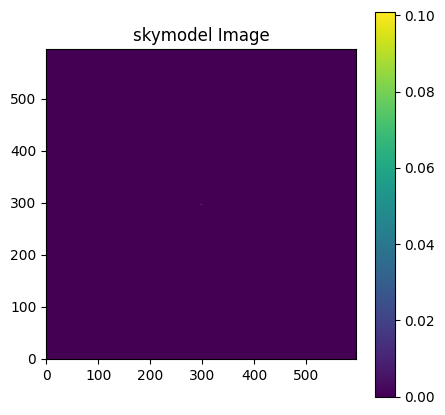

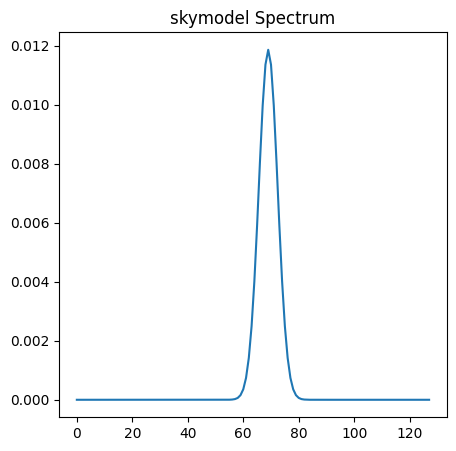

True brightness: 0.011862039828118462
Total brightness: 0.10101400337337303
Min brightness: 0.0
Peak brightness: 0.011862039828118462


2024-04-02 13:01:28	SEVERE	simobserve::MeasTable::dUTC(Double) (file /source/casa6/casatools/casacore/measures/Measures/MeasTable.cc, line 4290)	Leap second table TAI_UTC seems out-of-date.
2024-04-02 13:01:28	SEVERE	simobserve::MeasTable::dUTC(Double) (file /source/casa6/casatools/casacore/measures/Measures/MeasTable.cc, line 4290)+	Until the table is updated (see the CASA documentation or your system admin),
2024-04-02 13:01:28	SEVERE	simobserve::MeasTable::dUTC(Double) (file /source/casa6/casatools/casacore/measures/Measures/MeasTable.cc, line 4290)+	times and coordinates derived from UTC could be wrong by 1s or more.

0%....10....20....30....40....50....60....70....80....90....100%
....10....20....30....40....50....60....70....80....90....100%


Adding Atmospheric Noise using a scale factor of 0.5 for thropospheric phase
Found no unflagged data at:   (time=2014/01/01/00:05:03.0 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/00:13:37.0 field=1 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/00:22:11.1 field=2 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/00:30:45.2 field=3 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/00:39:19.3 field=4 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/00:47:53.4 field=5 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/00:56:27.4 field=6 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/01:05:01.5 field=7 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/01:13:35.6 field=8 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/01:22:09.7 field=9 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/01:30:43.8 field=10 spw=0 chan=0)
Found no unflagged data at:   (time=2014/0

2024-04-02 13:04:23	WARN	SynthesisParamsImage::buildCoordinateSystem (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2089)	imsize with 596 pixels is not an efficient imagesize. Try 600 instead.
2024-04-02 13:04:23	WARN	SynthesisParamsImage::buildCoordinateSystem (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2089)	imsize with 596 pixels is not an efficient imagesize. Try 600 instead.
2024-04-02 13:04:49	WARN	task_tclean::SynthesisParamsImage::buildCoordinateSystem (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SynthesisUtilMethods.cc, line 2089)	imsize with 596 pixels is not an efficient imagesize. Try 600 instead.
2024-04-02 13:04:56	WARN	task_tclean::SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2265)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


Saving Dirty and Clean Cubes
Sky total flux: 0.10101400337337303
Dirty total flux: 0.10423147
Sky peak flux: 0.011862039828118462
Dirty peak flux: 0.0012737869


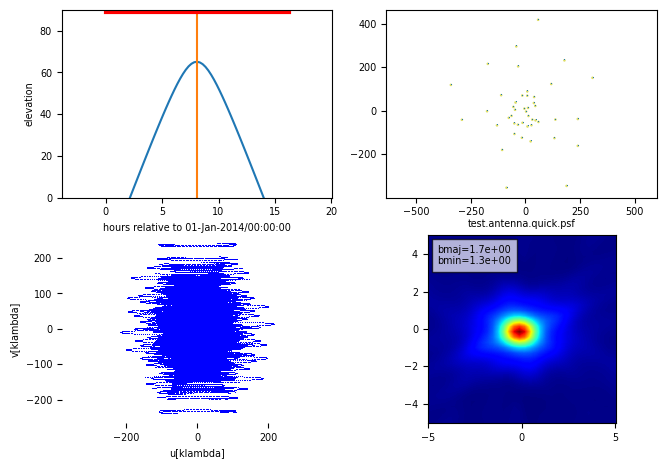

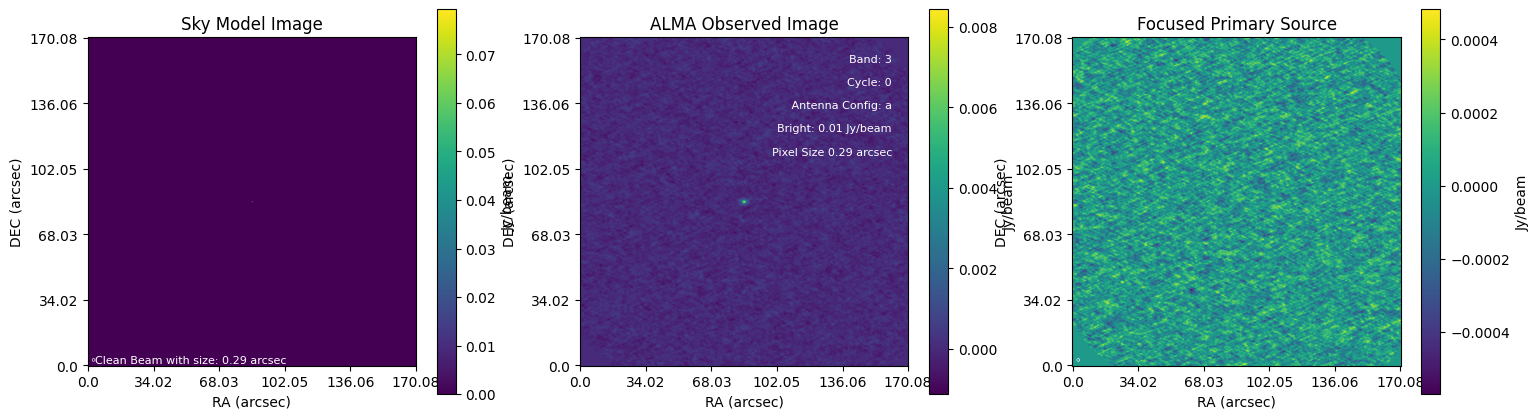

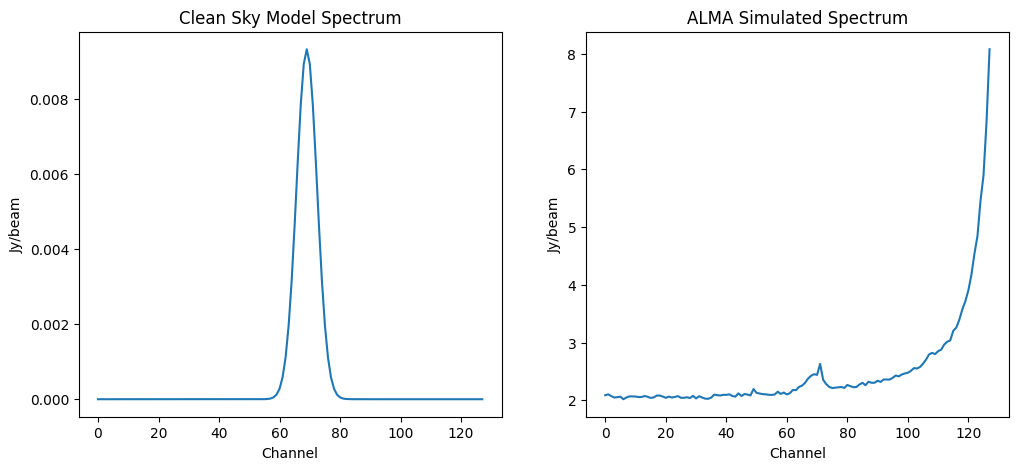

FileNotFoundError: [Errno 2] No such file or directory: '/home/astro/Documents/GitHub/ALMASim/experimental/test/skymodel_0.fits'

In [4]:
idx = 0
output_dir = current_path
plot_dir = current_path
project = 'test'
if not os.path.exists(os.path.join(output_dir, project)):
    os.mkdir(os.path.join(output_dir, project))
source_name = source_names[idx]
print(source_name)
ra = ras[idx]
dec = decs[idx]
band = bands[idx]
ang_res = ang_ress[idx]
vel_res = vel_ress[idx]
fov = fovs[idx]
obs_date = obs_dates[idx]
pwv = pwvs[idx]
int_time = int_times[idx] * U.s
total_time = total_times[idx] * U.s
bandwidth = bandwidths[idx]
freq = freqs[idx]
freq_support = freq_supports[idx]
#spatial_resolution = spatial_resolutions[idx]
central_freq = sm.get_band_central_freq(int(band)) * U.GHz
source_freq = freq * U.GHz
#print('central_freq given band {}: '.format(band), central_freq)
rest_frequency = 115.271 * U.GHz
radio_equivalence = U.doppler_radio(rest_frequency)
central_velocity = central_freq.to(U.km / U.s, equivalencies=radio_equivalence)
source_velocity = source_freq.to(U.km / U.s, equivalencies=radio_equivalence)
#print('central_velocity:', central_velocity)
#print('source_velocity:', source_velocity)
band_range = sm.get_band_range(int(band))

freq_sup = freq_supports[idx].split(' U ')[0].split(',')[1]
freq_sup = sm.remove_non_numeric(freq_sup)
freq_sup = float(freq_sup)
freq_sup = freq_sup * U.kHz
freq_sup = freq_sup.to(U.MHz)

print(band_range)
band_range = band_range[1] - band_range[0]
band_range = band_range * U.GHz
print('Band Width:', band_range)
band_range = band_range.to(U.MHz)
n_channels = int(band_range.value / freq_sup.value)
print(n_channels)
n_channels = 128
freq_sup = band_range / n_channels

fov = fov * U.deg
fov = fov.to(U.arcsec)
#print('FOV in arcsec:', fov)
def convert_range_from_GHz_to_km_s(central_freq, central_velocity, freq_range):
    freq_band = freq_range[1] - freq_range[0]
    freq_band = freq_band * U.GHz
    dv = (c * freq_band  / central_freq).to(U.km / U.s)
    return dv

#vel_range = convert_range_from_GHz_to_km_s(central_freq, central_velocity, band_range)
#print('Velocity Range:', vel_range)
#n_channels = int(vel_range.value / vel_res)
#print('n_channels:', n_channels)
#n_px = int(fov.value / ang_res)
#print('n_px:', n_px)

antenna_array = antenna_arrays[idx]
sm.generate_antenna_config_file_from_antenna_array(antenna_array, parent_dir, output_dir)

#antenna_config = sm.get_antenna_config_from_date(obs_date)
#antenna_id, cycle = antenna_config
#antenna_name = os.path.join('cycle{}'.format(int(cycle)), 'alma.cycle{}.0.{}'.format(int(cycle), int(antenna_id)))
#print('antenna_name:', antenna_name)
antennalist = os.path.join(output_dir, "antenna.cfg")
antenna_name = 'antenna'
max_baseline = sm.get_max_baseline_from_antenna_config(antennalist) * U.km
print('max_baseline:', max_baseline)
#antenna_name = os.path.split(antenna_name)[1]
#config_number = int(antenna_name.split('.')[-1])
import math

def estimate_alma_beam_size(central_frequency_ghz, max_baseline_km):
  """
  Estimates the beam size of the Atacama Large Millimeter/submillimeter Array (ALMA) in arcseconds.

  This function provides an approximation based on the theoretical relationship between
  observing frequency and maximum baseline. The formula used is:
  beam_size = (speed_of_light / central_frequency) / max_baseline * (180 / pi) * 3600 arcseconds
  [km]/[s] * [s] / [km] = [radians] * [arcsec /radian] * [arcseconds/degree]

  Args:
      central_frequency_ghz: Central frequency of the observing band in GHz (float).
      max_baseline_km: Maximum baseline of the antenna array in kilometers (float).

  Returns:
      Estimated beam size in arcseconds (float).

  Raises:
      ValueError: If either input argument is non-positive.
  """

  # Input validation
  if central_frequency_ghz <= 0 or max_baseline_km <= 0:
    raise ValueError("Central frequency and maximum baseline must be positive values.")

  # Speed of light in meters per second
  light_speed = c.to(U.m / U.s).value

  # Convert frequency to Hz
  central_frequency_hz = central_frequency_ghz.to(U.Hz).value

  # Convert baseline to meters
  max_baseline_meters = max_baseline_km.to(U.m).value


  # Theoretical estimate of beam size (radians)
  theta_radians = (light_speed / central_frequency_hz) / max_baseline_meters

  # Convert theta from radians to arcseconds
  beam_size_arcsec = theta_radians * (180 / math.pi) * 3600 * U.arcsec

  return beam_size_arcsec


beam_size = estimate_alma_beam_size(central_freq, max_baseline)
cell_size = beam_size / 5
experimental_fov = sm.get_fov_from_band(int(band))
n_px = 256
#vel_res = vel_res * U.km / U.s
print('n_px:', n_px)
print('cell_size:', cell_size)
#print('central_velocity:', central_velocity)
#print('source_velocity:', source_velocity)
#print('Velocity Range:', vel_range)

# Calculate the number of channels (including the very edge channels)
#num_channels = int(vel_range.value / vel_res.value) + 1
#num_channels = 128
#vel_res = vel_range / (num_channels - 1)
# Calculate the central channel index (assuming zero-based indexing)
central_channel_index = n_channels // 2
source_channel_index = int(central_channel_index * source_freq / central_freq)
print('Central Frequency:', central_freq)
print('Source Frequency:', source_freq)
print(f"Number of channels: {n_channels}")
print(f"Central channel: {n_channels // 2}")
print(f"Source channel: {source_channel_index}")
#print(f"Velocity resolution: {vel_res}")
print('Metadata FOV: ', fov)
print('Experimental FOV:', experimental_fov)
print('Band', band)
print('Angular Resolution', ang_res * U.arcsec)
print('beam_size:', beam_size)
print('cell_size:', cell_size)
image_fov = 3 * fov
n_px = int(image_fov / beam_size)
print('n_px:', n_px)
print('n_channels:', n_channels)

#ra = 0
#dec = 0
#n_px = 400

datacube = sm.DataCube(
  n_px_x=n_px, 
  n_px_y=n_px,
  n_channels=n_channels, 
  px_size=beam_size, 
  channel_width=freq_sup, 
  velocity_centre=central_freq, 
  ra=ra * U.deg, 
  dec=dec * U.deg)
wcs = datacube.wcs
pos_x, pos_y, _ = wcs.sub(3).wcs_world2pix(ra, dec, central_freq, 0)
pos_z = int(source_channel_index)
fwhm_z = np.random.randint(3, 10)

db = sm.sample_from_brightness(1, 100 * U.km / U.s * fwhm_z , rest_frequency.value, os.path.join(parent_dir, 'brightnes', 'CO10.dat'))
brightness = db['Brightness(Jy)'].values[0]
z = db['Redshift'].values[0]
print('brightness:', brightness)
print('z:', z)
#fwhm_z = 10

def insert_pointlike(datacube, amplitude, pos_x, pos_y, pos_z, fwhm_z, n_px, n_chan):
    z_idxs = np.arange(0, n_chan)
    g = sm.gaussian(z_idxs, 1, pos_z, fwhm_z)
    import scipy.integrate as integrate
    #integral = integrate.quad(lambda x: sm.gaussian(x, 1, pos_z, fwhm_z), min(z_idxs), max(z_idxs))
    #g /= integral[0]
    ts = np.zeros((n_px, n_px, n_chan))
    ts[int(pos_x), int(pos_y), :] = amplitude
    for z in range(datacube._array.shape[2]):
        slice_ = g[z] * ts[:, :, z]
        datacube._array[:, :, z] += slice_ * U.Jy * U.pix**-2
    return datacube
print(pos_x, pos_y)
datacube = insert_pointlike(datacube, brightness, pos_x, pos_y, pos_z, fwhm_z, n_px, n_channels)
filename = os.path.join(output_dir, project, 'skymodel_{}.fits'.format(idx))
sm.write_datacube_to_fits(datacube, filename)
sm.plot_skymodel(filename, idx, plot_dir, show=True)
skymodel, sky_header = sm.load_fits(filename)
true_brightness = np.max(skymodel)
total_brightness = np.sum(skymodel)
min_brightness = np.min(skymodel)
print('True brightness:', true_brightness)
print('Total brightness:', total_brightness)
print('Min brightness:', min_brightness)
peak_brightness = np.max(skymodel)
print('Peak brightness:', peak_brightness)
#freq_res = (band_range[1] - band_range[0]) / 128 * U.GHz
#print('Frequency resolution:', freq_res.to(U.MHz))
pos_string = convert_to_j2000_string(ra, dec)
simobserve(
    project=project, 
    skymodel=filename,
    obsmode="int",
    setpointings=True,
    thermalnoise="tsys-atm",
    antennalist=antennalist,
    indirection=pos_string,
    #indirection="J2000 19h30m00 -40d00m00",
    incell="{}arcsec".format(beam_size.value),
    incenter='{}GHz'.format(central_freq.value),
    inwidth="{}MHz".format(freq_sup.value),
    integration="{}s".format(int_time.value),
    totaltime="{}s".format(total_time.value),
    user_pwv=pwv,
    )
scale = 0.5
print('Adding Atmospheric Noise using a scale factor of {} for thropospheric phase'.format(scale))
    # scale is a multiplicative factor for the thropospheric phase 
    # which is a delay in the propagation of radio waves in the atmosphere
    # caused by the refractive index of the throphosphere
sm.simulate_atmospheric_noise(
    os.path.join(output_dir, project), 
    scale, 
    os.path.join(output_dir, project, "{}.{}.noisy.ms".format(project, antenna_name)), 
    antennalist)
gain_error_amplitude = random.gauss(0.001, 0.1)
sm.simulate_gain_errors(
    os.path.join(output_dir, project, "{}.{}.noisy.ms".format(project, antenna_name)),
    gain_error_amplitude
)
tclean(
    vis=os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
    imagename=os.path.join(project, '{}.{}'.format(project, antenna_name)),
    imsize=[int(n_px), int(n_px)],
    cell="{}".format(beam_size),
    phasecenter=pos_string,
    specmode="cube",
    niter=0,
    fastnoise=False,
    calcpsf=True,
    pbcor=True,
    pblimit=0.2, 
    )

print('Saving Dirty and Clean Cubes')
exportfits(imagename=os.path.join(project, '{}.{}.image'.format(project, antenna_name)), 
       fitsimage=os.path.join(output_dir, "dirty_cube_" + str(idx) +".fits"), overwrite=True)
exportfits(imagename=os.path.join(project, '{}.{}.skymodel'.format(project, antenna_name)), 
        fitsimage=os.path.join(output_dir, "clean_cube_" + str(idx) +".fits"), overwrite=True)
clean, clean_header = sm.load_fits(os.path.join(output_dir, "clean_cube_" + str(idx) +".fits"))
dirty, dirty_header = sm.load_fits(os.path.join(output_dir, "dirty_cube_" + str(idx) +".fits"))
sky_total_flux = np.nansum(skymodel)
dirty_total_flux = np.nansum(dirty)
sky_peak_flux = np.nanmax(skymodel)
dirty_peak_flux = np.nanmax(dirty)
print('Sky total flux:', sky_total_flux)
print('Dirty total flux:', dirty_total_flux)
print('Sky peak flux:', sky_peak_flux)
print('Dirty peak flux:', dirty_peak_flux)

run_tclean = False
cycle = str(0)
sm.plotter(idx, output_dir, plot_dir, run_tclean, band, cycle, peak_brightness, beam_size.value, beam_size.value, antenna_name, fwhm_z, show=True)
shutil.rmtree(project)

os.remove(filename)
os.remove(os.path.join(output_dir, "dirty_cube_" + str(idx) +".fits"))
os.remove(os.path.join(output_dir, "clean_cube_" + str(idx) +".fits"))
print('Done')




In [4]:


pos_string = convert_to_j2000_string(ra, dec)
print(pos_string)

NameError: name 'ra' is not defined